In [1]:
import logging
import tensorflow as tf


GPU_FROM = 2
GPU_TO = 3  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")

2023-01-25 13:02:59.255537: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 13:02:59.402622: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-25 13:02:59.439124: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-25 13:03:00.091460: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
import string
import html
import tensorflow_datasets as tfds

from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

gap = 3
len = 100

punc_mapping = {ord(x):x for x in string.punctuation}
entity_mapping = {f" ?{k}": v for k, v in html.entities.html5.items() if k.endswith(";") and v in string.punctuation}
punc_mapping = {f' ?&?#?{k};': v for k, v in punc_mapping.items()}

train, test = tfds.load('ag_news_subset', split="train"), tfds.load('ag_news_subset', split="test")

def unescape(text):
    for match, replace in punc_mapping.items():
        text = tf.strings.regex_replace(text, match, replace)
    for match, replace in entity_mapping.items():#
        text = tf.strings.regex_replace(text, match, replace)
    return text

def join_title_desc(text_dict):
    return text_dict['title'] + ' ' + text_dict['description']

def remove_space(text):
    return tf.strings.reduce_join(tf.strings.strip(tf.strings.split(text)), axis=-1)

def space_after_letter(letter):
    def replacer(x):
        x = tf.strings.regex_replace(x, f"({letter})", r"\1 ") # add whitespace back in after every letter e
        return x
    return replacer

train = train.map(join_title_desc).map(unescape).map(remove_space)
test = test.map(join_title_desc).map(unescape).map(remove_space)

for x in train.take(1):
    print(x)

/home/ma/a/al3615/tf_210/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-25 13:03:04.939111: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-25 13:03:05.599221: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 2, name: GeForce RTX 3090, pci bus id: 0000:86:00.0, compute capability: 8.6


tf.Tensor(b"AMDDebutsDual-CoreOpteronProcessorAMD'snewdual-coreOpteronchipisdesignedmainlyforcorporatecomputingapplications,includingdatabases,Webservices,andfinancialtransactions.", shape=(), dtype=string)


2023-01-25 13:03:06.491126: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [3]:

def generate_labels(text):
    text = tf.strings.substr(text, 0, 100)
    text = tf.strings.lower(text)
    encoder_in = text
    encoder_out = tf.strings.regex_replace(text, r"[^e]", "1") # 1 indicates character
    encoder_out = tf.strings.regex_replace(encoder_out, r"e", "2") # 2 indicates space
    encoder_out = tf.strings.bytes_split(encoder_out)
    encoder_out = tf.strings.to_number(encoder_out)
    encoder_out = tf.pad(encoder_out, [[0,100-tf.shape(encoder_out)[0]]])

    return (encoder_in, None), encoder_out

train = train.map(generate_labels)
val = test.map(generate_labels)
for x in train.take(1):
    print(x)

((<tf.Tensor: shape=(), dtype=string, numpy=b"amddebutsdual-coreopteronprocessoramd'snewdual-coreopteronchipisdesignedmainlyforcorporatecomputinga">, None), <tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>)


2023-01-25 13:03:06.925195: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [4]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train.take(1000).map(lambda x,y: x[0]))
tokenizer.get_vocabulary()

2023-01-25 13:03:09.956188: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


['',
 '[UNK]',
 'e',
 'a',
 't',
 's',
 'o',
 'i',
 'n',
 'r',
 'l',
 'd',
 'h',
 'c',
 'u',
 'p',
 'm',
 'f',
 'g',
 'b',
 'y',
 'w',
 'k',
 'v',
 '-',
 ',',
 '.',
 "'",
 '(',
 ')',
 '0',
 'x',
 'j',
 '2',
 '1',
 'q',
 '&',
 ':',
 'z',
 '4',
 '3',
 '\\',
 '5',
 '"',
 '<',
 '>',
 '/',
 '7',
 '6',
 '$',
 '8',
 '9',
 ';',
 '?',
 '=',
 '#',
 '!',
 '*']

In [5]:
for x in train.take(1):
    print(x)
    tokens = tokenizer(x[0][0])
    print(tokens)
    space_tokens = tf.where(tokens == 2, tokens, 3) # Just happen to know e tokenizes to 2 - messy af
    print(tf.cast(tf.where(x[1] == 2, x[1], 7), dtype=space_tokens.dtype) == space_tokens) # TODO: investigate what is going on here

((<tf.Tensor: shape=(), dtype=string, numpy=b"amddebutsdual-coreopteronprocessoramd'snewdual-coreopteronchipisdesignedmainlyforcorporatecomputinga">, None), <tf.Tensor: shape=(100,), dtype=float32, numpy=
array([1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       2., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2.,
       1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1.,
       1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)>)
tf.Tensor(
[ 3 16 11 11  2 19 14  4  5 11 14  3 10 24 13  6  9  2  6 15  4  2  9  6
  8 15  9  6 13  2  5  5  6  9  3 16 11 27  5  8  2 21 11 14  3 10 24 13
  6  9  2  6 15  4  2  9  6  8 13 12  7 15  7  5 11  2  5  7 18  8  2 11
 16  3  7  8 10 20 17  6  9 13  6  9 15  6  9  3  4  2 13  6 16 15 14  4
  7  8 18  3], shape=(100,

2023-01-25 13:03:10.430644: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
D_MODEL = 512

model = SpaceSegmentationTransformer(
    num_layers=2,
    d_model=D_MODEL,
    num_attention_heads=3,
    seq_len=100,
    dff=1028,
    input_tokenizer=tokenizer,
    dropout_rate=0.1
)

In [7]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=200):
        super().__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return 2* tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=0.),
        SparsePrecision(class_id=2, name="space_precision"),
        SparseRecall(class_id=2, name="space_recall"),
        SparseF1(class_id=2, name="space_f1"),
        SparsePrecision(class_id=1, name="char_precision"),
        SparseRecall(class_id=1, name="char_recall"),
        SparseF1(class_id=1, name="char_f1"),
    ]
)

In [8]:
train_ds = train.shuffle(100).batch(8)
val_ds = val.batch(8)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_space_precision",
        patience=30,
        mode="max",
        restore_best_weights=True
    )
]

history = model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=callbacks, steps_per_epoch=1000)

Epoch 1/30
   7/1000 [..............................] - ETA: 21s - loss: 1.0112 - sparse_categorical_accuracy: 0.6108 - space_precision: 0.1042 - space_recall: 0.0342 - space_f1: 0.0515 - char_precision: 0.9142 - char_recall: 0.6781 - char_f1: 0.7787   

2023-01-25 13:03:15.582079: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1000/1000 [==============================] - 39s 35ms/step - loss: 0.0074 - sparse_categorical_accuracy: 0.9972 - space_precision: 0.9979 - space_recall: 0.9930 - space_f1: 0.9955 - char_precision: 0.9981 - char_recall: 0.9977 - char_f1: 0.9979 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 0.9986 - val_char_recall: 1.0000 - val_char_f1: 0.9993
Epoch 2/30
1000/1000 [==============================] - 33s 33ms/step - loss: 1.7881e-12 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 0.9989 - char_recall: 1.0000 - char_f1: 0.9994 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 0.9986 - val_char_recall: 1.0000 - val_char_f1: 0.9993
Epoch 3/30
1000/1000 [=============================

1000/1000 [==============================] - 11s 11ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 0.9988 - char_recall: 1.0000 - char_f1: 0.9994 - val_loss: 0.0000e+00 - val_sparse_categorical_accuracy: 1.0000 - val_space_precision: 1.0000 - val_space_recall: 1.0000 - val_space_f1: 1.0000 - val_char_precision: 0.9986 - val_char_recall: 1.0000 - val_char_f1: 0.9993


In [9]:
model.evaluate(val_ds)

950/950 [==============================] - 13s 13ms/step - loss: 0.0000e+00 - sparse_categorical_accuracy: 1.0000 - space_precision: 1.0000 - space_recall: 1.0000 - space_f1: 1.0000 - char_precision: 0.9986 - char_recall: 1.0000 - char_f1: 0.9993


[0.0, 1.0, 1.0, 1.0, 1.0, 0.9986254572868347, 1.0, 0.9993122220039368]

In [10]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'space_precision', 'space_recall', 'space_f1', 'char_precision', 'char_recall', 'char_f1', 'val_loss', 'val_sparse_categorical_accuracy', 'val_space_precision', 'val_space_recall', 'val_space_f1', 'val_char_precision', 'val_char_recall', 'val_char_f1'])

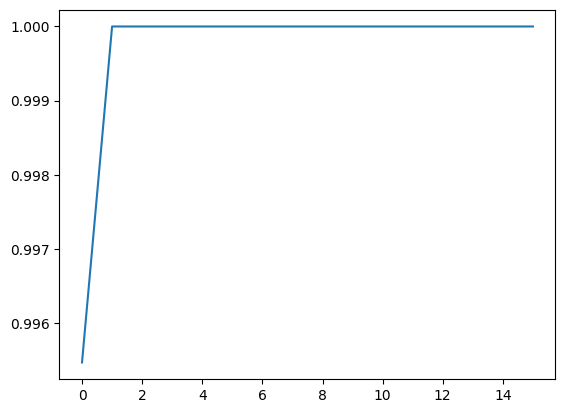

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['space_f1'])

In [15]:
preds = model([("dunningkruger", "eeeeeeeeeeeeeeeeeeeee", "thequickbrownfoxjumpedoverthelazydog"),(None,None, None)])
preds, tf.argmax(preds, axis=-1)

(<tf.Tensor: shape=(3, 100, 3), dtype=float32, numpy=
 array([[[-1.72272511e+01,  1.08881941e+01, -1.82745438e+01],
         [-1.72941208e+01,  1.02743559e+01, -1.85116863e+01],
         [-1.63078632e+01,  1.19491501e+01, -1.83472385e+01],
         [-1.61852188e+01,  1.22892437e+01, -1.82589092e+01],
         [-1.66375103e+01,  1.14915848e+01, -1.88646717e+01],
         [-1.61403446e+01,  1.25418501e+01, -1.79797649e+01],
         [-1.69376698e+01,  1.07281914e+01, -1.85887012e+01],
         [-1.63964405e+01,  1.19633036e+01, -1.81003876e+01],
         [-1.61507835e+01,  1.30331736e+01, -1.85830135e+01],
         [-1.70402699e+01,  1.15131435e+01, -1.85363483e+01],
         [-1.72560482e+01,  1.10907679e+01, -1.88165359e+01],
         [-1.93194408e+01, -1.99273071e+01,  8.69643211e+00],
         [-1.63327370e+01,  1.33591204e+01, -1.84804802e+01],
         [-1.46408854e+01,  3.36835456e+00, -1.70105381e+01],
         [-1.46143618e+01,  3.43356252e+00, -1.70836315e+01],
         [-1.463

In [ ]:
model.encoder.pos_embedding(tokenizer(["e"]))

In [ ]:
model.encoder.pos_embedding(tokenizer(["d"]))

In [ ]:
import lovely_tensors as lt
lt.monkey_patch()
a = [print(x) for x in model.trainable_variables]